<DIV ALIGN=CENTER>

# Introduction to Anomaly Detection
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore the concept of anomaly detection,
where one tries to find points or groups of points that do not belong
with other points, groups, or clusters of data points. Any point that is
affiliated with a group or cluster of _normal_ data is considered an
_inlier_ while any point that is not associated with a group or cluster
is called an _outlier_. 

One of the most effective ways to identify anomalies is to visually
explore the data, which can often indicate statistical approaches that
can robustly identify and mitigate the effects of outliers on subsequent
analyses. Anomaly detection is often closely tied to clustering, and in
fact the [DBSCAN][db] algorithm indicates _noise_ points that are not
assigned to any specific cluster. Other approaches will employ
classification techniques that build a model of the data to identify
points that are inliers or outliers. In this Notebook, we explore all of
these techniques. 

-----
[db]: https://en.wikipedia.org/wiki/DBSCAN

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

-----

### Anomaly Detection: Visual Analysis

We will being by visualizing the distribution of the original data.
First, we will explore the one-dimensional distribution of each feature.
Second, we explore the bi-variate distribution of the data. These
visualizations make use of techniques we covered in a [previous
Notebook][kden] on kernel density estimation. The goal of these
visualizations is to better understand the _expected distribution_ of
the data of interest. Without this insight, identifying outliers is
considerably more challenging. In some cases, one can construct rules
directly from these visualization to cull or remove many clear and
obvious outliers. In this case, our data are clean, but we will shortly
begin adding different types of outliers or noise into these
distributions.

-----

[kden]: ../../Week5/notebooks/intro2de.ipynb

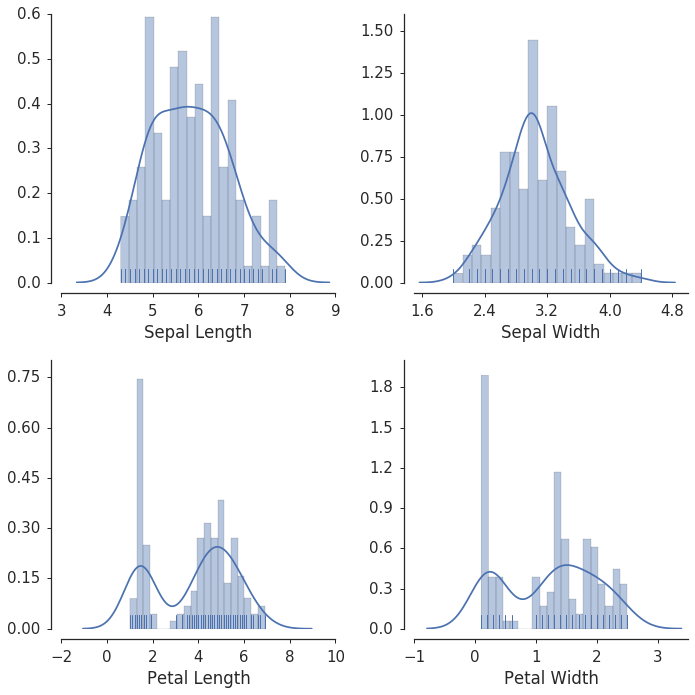

In [2]:
# Grab the iris data, modify column names for pretty plotting

iris = sns.load_dataset('iris')
iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']

from matplotlib.ticker import MaxNLocator

# Function to nicely plot a one-dimensional distribution
def plot_oned(data, axs):
    sns.distplot(data, bins=20, kde=True, rug=True, norm_hist=True, ax=axs)
    axs.xaxis.set_major_locator(MaxNLocator(6))
    axs.yaxis.set_major_locator(MaxNLocator(7))
    sns.despine(offset=10)

# Make a box plot to show distributions
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Now plot all four distributions.
plot_oned(iris['Sepal Length'], axs[0][0])
plot_oned(iris['Sepal Width'], axs[0][1])
plot_oned(iris['Petal Length'], axs[1][0])
plot_oned(iris['Petal Width'], axs[1][1])
plt.tight_layout()

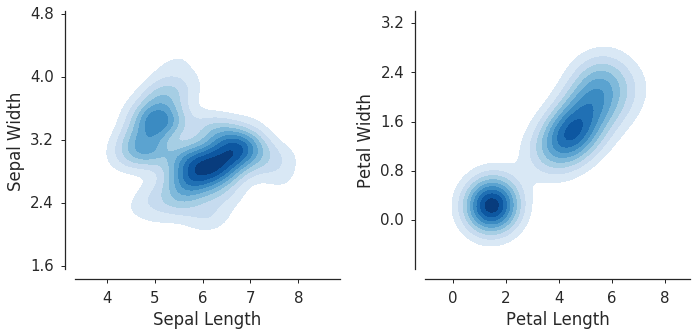

In [3]:
# Plot a two-distribution
def plot_twod(x, y, axs):
    sns.kdeplot(x, y, cmap="Blues", shade=True, shade_lowest=False, ax=axs)
    axs.xaxis.set_major_locator(MaxNLocator(6))
    axs.yaxis.set_major_locator(MaxNLocator(6))
    #axs.set_aspect('equal')
    sns.despine(offset=10)

# Setup the plot and make 2d visualizations
sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_twod(iris['Sepal Length'], iris['Sepal Width'], axs[0])
plot_twod(iris['Petal Length'], iris['Petal Width'], axs[1])
plt.tight_layout()

-----

### Outlier Types

At this point, we have repeatedly analyzed the Iris data, and recognize
that there are three clear clusters of points (associated with the three
Iris types in the sample). These visualizations demonstrate the clear
separation of these classes, particularly in the petal measurements. In
this notebook, however, we want to identify outlier points, which are
not present in the original data. As a result, we now modify the
original data to include three different types of outlier points:

1. Extreme values
2. Transposed data
3. Incorrect measurements

Extreme values are points that follow the expected distributions, but
have unusually high scatter. We demonstrate these points below (in green)
by modeling a feature column as a Gaussian distribution and sampling
high variance points from this model. Second, we indicate possible human
error by adding new data points that are existing data points whose
columns have been transposed (e.g., switching _Sepal Length_ and _Sepal
Width_). Finally, Incorrect measurements represent data that might be
incorrectly obtained or the result of either human or machine error. In
this case, we simply change the measurements from centimeters to inches
for a sample of data. These new data are displayed, along with the
original data, clearly demsonstraintg the modification to the original
distribution.

-----

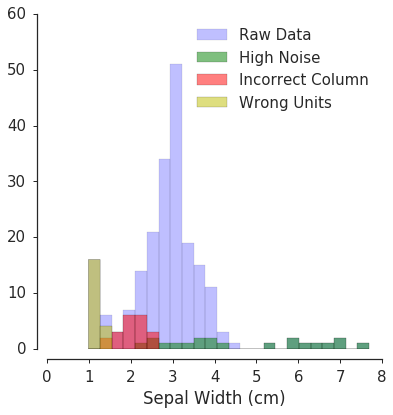

In [4]:
from scipy.stats import uniform

data = iris['Sepal Width']
mu = np.mean(data)
sig = np.std(data)

# Add some extreme outliers
x = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
x = np.append(x, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

x = np.append(x, iris['Petal Width'][-20:], axis=0)
x = np.append(x, iris['Sepal Width'][-20:]/2.54, axis=0)

fig, axs = plt.subplots(figsize=(6, 6))

def hist_oned(x, xlbl, axs):
    bins=np.linspace(np.min(x), np.max(x), 25)
    axs.hist(x, bins=bins, color='b', alpha=0.25, label='Raw Data')
    axs.hist(x[-60:-40], bins=bins, color='g', alpha=0.5, label='High Noise')
    axs.hist(x[-40:-20], bins=bins, color='r', alpha=0.5, label='Incorrect Column')
    axs.hist(x[-20:], bins=bins, color='y', alpha=0.5, label='Wrong Units')

    plt.legend(loc='best')
    axs.set_xlabel(xlbl)
    sns.despine(offset=10)
    
hist_oned(x, 'Sepal Width (cm)', axs)
plt.show()

-----

### Anomaly Detection: Statistical Analysis

The previous visualization demonstrates how the outliers have modified
the original data distribution. While many points are clearly visible,
some are harder to find (and in fact may be impossible to separate from
the original data). After a visualization demonstrates the clear
presence of outliers, the next step is to statistically analyze the
distribution. We first can compute the standard statistical
summarizations of the distribution, including the mean and standard
deviation, as well as more robust statistical measurements, include the
median and trimmed mean and trimmed standard deviation. These latter
quantities are less sensitive to outliers and thus can provide more
insight into the _good_ measurements within a data set.

In the following cells, we first compute these quantities for the
original and modified data, before plotting the one-dimensional
distribution of the modified data, on which we overplot the two- and
three-sigma errors, as computed from the trimmed mean and trimmed
standard deviation. Notice how, as expected from a Gaussian
distribution, the data outside the three-sigma error bars are nearly
exclusively some type of added noise. This has been a simple example of
using statistical techniques to identify outliers, there are a number of
more complicated techniques that can be used. In some cases, these
techniques are adapted to particular types of distributions, such as the
Normal distribution that this particular feature (_Sepal Width_)
follows. Further exploration of these techniques, however, is outside
the scope of this Notebook.

-----

In [5]:
from scipy import stats

mu = np.mean(x[:-60]); sig = np.std(x[:-60])

print('Statistics for Original Data:\n', 25*'-')
print('Median = {0:4.3f}'.format(np.median(x[:-60])))
print('Mean = {0:4.3f}'.format(mu))
print('Std Dev = {0:4.3f}'.format(sig))
print('Trimmed Mean ({1:3.2f}) = {0:4.3f}'.format(stats.tmean(x, (mu - sig, mu + sig)), sig))
print('Trimmed Std ({1:3.2f}) = {0:4.3f}'.format(stats.tstd(x, (mu - sig, mu + sig)), sig))

mu = np.mean(x); sig = np.std(x)

print('\nStatistics for Noisy Data:\n', 25*'-')
print('Median = {0:4.3f}'.format(np.median(x)))
print('Mean = {0:4.3f}'.format(mu))
print('Std Dev = {0:4.3f}'.format(sig))
print('Trimmed Mean ({1:3.2f}) = {0:4.3f}'.format(stats.tmean(x, (mu - sig, mu + sig)), sig))
print('Trimmed Std ({1:3.2f}) = {0:4.3f}'.format(stats.tstd(x, (mu - sig, mu + sig)), sig))

Statistics for Original Data:
 -------------------------
Median = 3.000
Mean = 3.057
Std Dev = 0.434
Trimmed Mean (0.43) = 3.038
Trimmed Std (0.43) = 0.210

Statistics for Noisy Data:
 -------------------------
Median = 3.000
Mean = 2.940
Std Dev = 1.049
Trimmed Mean (1.05) = 2.954
Trimmed Std (1.05) = 0.464


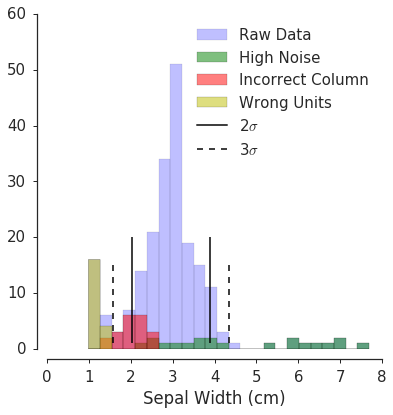

In [6]:
fig, axs = plt.subplots(figsize=(6, 6))

hist_oned(x, 'Sepal Width (cm)', axs)

tmu = stats.tmean(x, (mu - sig, mu + sig))
tsig = stats.tstd(x, (mu - sig, mu + sig))

xl = [(tmu - 2.0 * tsig), (tmu + 2.0 * tsig)]
axs.vlines(xl, ymax = 20, ymin = 1, linestyle='-', \
           lw=2, alpha = 0.75, label='2$\sigma$')

xl = [(tmu - 3.0 * tsig), (tmu + 3.0 * tsig)]
axs.vlines(xl, ymax = 15, ymin = 1, linestyle='--',\
           lw=2, alpha = 0.75, label='3$\sigma$')

plt.legend(loc='best')
plt.show()

-----

To this point, we have visually explored outlier detection in
one-dimension. Often, however, outlier detection can be more easily
performed by exploring the data in more dimensions. We now explore the
Iris data in two-dimensions, by looking at both the Sepal Width_
feature and the _Sepal Length_ feature. We first construct the _Sepal
Length_ one-dimensional data to match the _Sepal _Width data, for
example by matching the three types of outliers we previously
constructed for the _Sepal Width_ feature. Next, we plot the _Sepal
Length_ one-dimensional distribution, which more clearly separates out
the data with incorrect units. Finally, in the second code cell, we
display the bivariate distribution of _Sepal Width_ and _Sepal Length_,
which visually indicates the distribution of normal data, along with the
different types of outliers. It is to this two-dimensional distribution
that we will apply more sophisticated machine learning techniques. 

-----

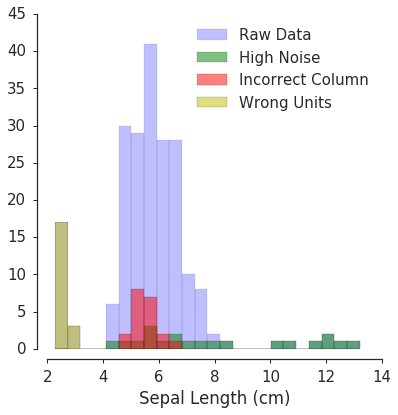

In [7]:
data = iris['Sepal Length']
mu = np.mean(data)
sig = np.std(data)

# Add some extreme outliers
y = np.append(data, (mu - 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))
y = np.append(y, (mu + 2.0 * sig) * uniform.rvs(0.9, 1.1, size=10))

y = np.append(y, iris['Petal Length'][-20:], axis=0)
y = np.append(y, iris['Sepal Length'][-20:]/2.54, axis=0)

fig, axs = plt.subplots(figsize=(6, 6))

hist_oned(y, 'Sepal Length (cm)', axs)
plt.show()

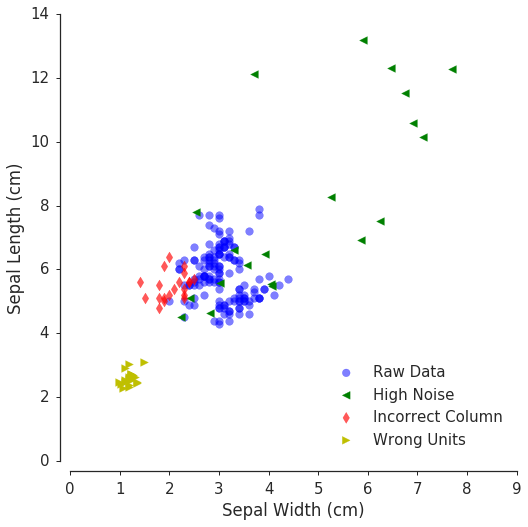

In [8]:
fig, axs = plt.subplots(figsize=(8, 8))
    
plt.scatter(x[:-60], y[:-60], color='b', s=60, alpha=0.5, label='Raw Data')
plt.scatter(x[-60:-40], y[-60:-40], color='g', s=60, marker='<', label='High Noise')
plt.scatter(x[-40:-20], y[-40:-20], color='r', s=60, marker='d', alpha=0.65, label='Incorrect Column')
plt.scatter(x[-20:], y[-20:], color='y', s=60, marker='>', label='Wrong Units')

plt.legend(loc=4)
axs.set_xlabel('Sepal Width (cm)')
axs.set_ylabel('Sepal Length (cm)')
sns.despine(offset=10)
plt.show()

-----

### Anomaly Detection: Cluster Analysis

At its core, anomaly detection is often considered to be identifying
points that are different from the majority of the data under analysis.
In this case, one can view the problem as finding the clusters of normal
data, and using these clusters to identify data that are outside, or
_outliers_, the normal data groupings inherent within the data. In this
approach, we often will start with a clustering technique that does not
require an initial estimate for the number of clusters (although if we
know _how our data are normally distributed_, we can use this _a priori_
information to guide the process). 

As a result, clustering techniques like DBSCAN, which we covered in a
[previous Notebook][w5l2], are useful since they both identify clusters
and points (called _noise_) that are outside the clusters. In the
following two cells, we first apply the DBSCAN algorithm on our modified
Iris data set to find clusters, noise points, and finally, in the second
cell, to plot the results for comparison. Recall that when using DBSCAN,
points labeled as `class=-1` are considered noise points.


-----
[w5l2]: ../../Week5/notebooks/intro2cluster.ipynb

In [9]:
# We will use DBSCAN from scikit-learn
from sklearn.cluster import DBSCAN

data = np.array((x, y)).T
dbs = DBSCAN(eps=0.25, min_samples=10)
dbs.fit(data)

from collections import Counter

print('DBSCAN Cluster membership:\n', 25*'-')
for key, val in Counter(dbs.labels_).most_common():
    print('Class {0:2d} has {1:3d} members'.format(key, val))

DBSCAN Cluster membership:
 -------------------------
Class  1 has  85 members
Class -1 has  71 members
Class  0 has  36 members
Class  2 has  18 members


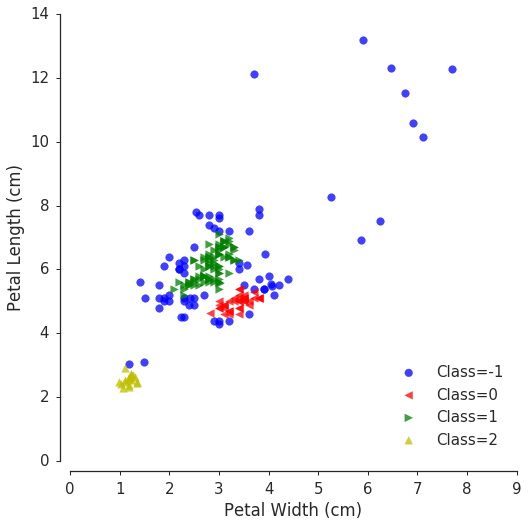

In [10]:
def make_plot(df, axs, lbl, c, m):
    xx = df[df.Label==lbl][['SW']]
    yy = df[df.Label==lbl][['SL']]
    axs.scatter(xx, yy, color=c, marker=m, alpha =0.75, s=60, label='Class={0}'.format(lbl))

df = pd.DataFrame({'SW': x, 'SL': y, 'Label': dbs.labels_})

fig, axs = plt.subplots(figsize=(8, 8))

ca = ['b', 'r', 'g', 'y', 'c']
ma = ['o', '<', '>', '^', 'v']

for idx, lbl in enumerate(np.unique(dbs.labels_)):
    make_plot(df, axs, lbl, ca[idx], ma[idx])

plt.legend(loc=4)
axs.set_xlabel('Petal Width (cm)')
axs.set_ylabel('Petal Length (cm)')
sns.despine(offset=10)
plt.show()

-----

### Anomaly Detection: Classification Analysis

One seemingly obvious technique for identifying anomalies is to employ
classification to identify data that are somehow different. While this
may sound simple, in practice it can be difficult. For example, how do
you define _different_ and from what, exactly are new points different?
The basic concept is to construct a model from _good_ data and use this
model to identify anomalies. But without knowing the _good_ data, this
process is made considerably more complicated.

A simple approach to this problem is to start with _some_ of the data to
build the initial model, and to identify the likelihood that _new_ data
are inliers or outliers. Alternatively, one can perform a one versus
the rest classification method to quantify the likelihood that each
point is affiliated with the others, via the construction of a _support_
measurement. A simple technique that implements these approaches is
provided in scikit learn via [One Class SVM][skocsvm]. This
classification method takes input data with no labels and builds a model
of the data. This model can be used to quantify the support and to
identity the likelihood that new points are in the model or out of the
model. 

We demonstrate this algorithm in the following code cell by using the
modified _Iris_ data we constructed previously in this Notebook. We
first construct a sample of points in a two-dimensional space (for the
_Sepal Width_ and _Sepal Length_) by using a `meshgrid`. Next, we create
the classifier, train it using the modified data, and apply it to the
mesh grid and data points to determine the likelihood that points are
inliers or outliers.

-----

[skocsvm]: http://scikit-learn.org/stable/modules/svm.html#svm-outlier-detection

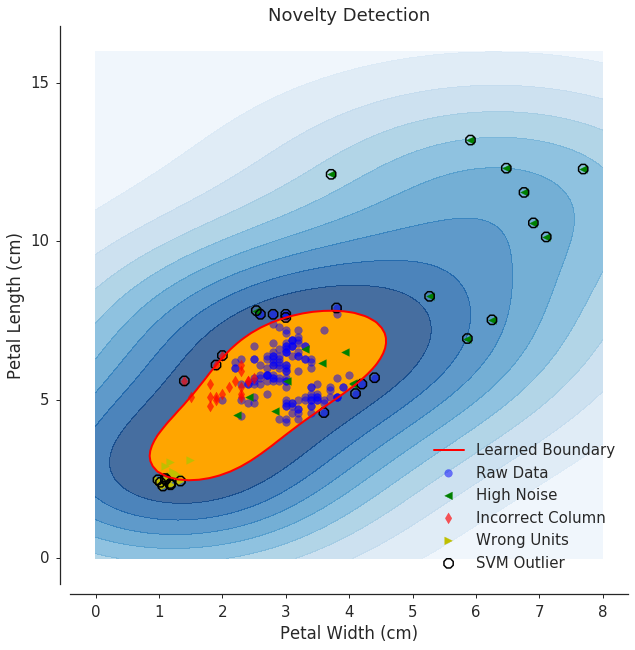

In [11]:
# Modified from scikit learn
# http://scikit-learn.org/stable/auto_examples/covariance/plot_outlier_detection.html

from sklearn import svm
from sklearn.preprocessing import scale

xx, yy = np.meshgrid(np.linspace(0, 8, 50), np.linspace(0, 16, 100))

# scikit learn recommended formula
of = 0.1 # Expected Outlier Fraction
nuv = 0.95 * of + 0.05

svc = svm.OneClassSVM(nu=nuv, kernel="rbf", gamma=0.1)
svc.fit(data)
preds = svc.predict(data)

z = svc.decision_function(np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

fig, axs = plt.subplots(figsize=(10, 10))

plt.title("Novelty Detection")
plt.contourf(xx, yy, z, levels=np.linspace(z.min(), 0, 10), cmap=plt.cm.Blues, alpha=0.75)
a = plt.contour(xx, yy, z, levels=[0], linewidths=2, colors='red')
plt.contourf(xx, yy, z, levels=[0, z.max()], colors='orange')

p1 = plt.scatter(x[:-60], y[:-60], color='b', s=60, alpha=0.5)
p2 = plt.scatter(x[-60:-40], y[-60:-40], color='g', s=60, marker='<')
p3 = plt.scatter(x[-40:-20], y[-40:-20], color='r', s=60, marker='d', alpha=0.65)
p4 = plt.scatter(x[-20:], y[-20:], color='y', s=60, marker='>')

# Now mark the outliers, they have prediction class = -1. 
# To simplify finding them we use a temporary DataFrame
df = pd.DataFrame({'x': x, 'y': y, 'p': preds})
p5 = plt.scatter(df[df.p < 0].x, df[df.p < 0].y, s=100, \
                 marker='8', facecolor='none', edgecolor='black', \
                 linewidth=1.5, linestyle='-')

# Draw the full legend. We do this manually since we use different
# plotting techniques.
axs.legend([a.collections[0], p1, p2, p3, p4, p5], \
           ['Learned Boundary', 'Raw Data', 'High Noise', \
            'Incorrect Column', 'Wrong Units', 'SVM Outlier'], loc=4)

axs.set_xlabel('Petal Width (cm)')
axs.set_ylabel('Petal Length (cm)')
sns.despine(offset=10)
plt.show()

-----

## Student Activity

In the preceding cells, we used several outlier detection techniques to
identify manually added outliers to the Iris data. Now that you have run
the Notebook, go back and make the following changes to see how the
results change.

1. Change the number of outlier points added to the two _Sepal_
features, including noise points, transposed columns, and incorrect
measurements. How does this visually change the distribution? How does it
affect the statistical summarizations?
2. Change the parameters used in the DBSCAN algorithm. How does this
affect the outlier detection? How does bandwidth used in the KDE
estimator. How does this affect the resulting plot?
3. Try using a different kernel function, for example a `linear` or
`poly` with the `OneClassSVM`. How does this affect the outlier
detection process?

Finally, the previous cells only modified the _Sepal_ features, try
making four-dimensional fake data by creating fake _Petal_ features as
well. Can you still apply the demonstrated techniques to the four
dimensional data set.

-----

## Handwritten Digits

Now we switch to a second type of data and explore outlier detection with the
handwritten digit data set. First we will load the data and review some
of the sample. After which, we will create some _fake_ data to look at
outliers in the digit data set.

-----

Total number of samples = 1797


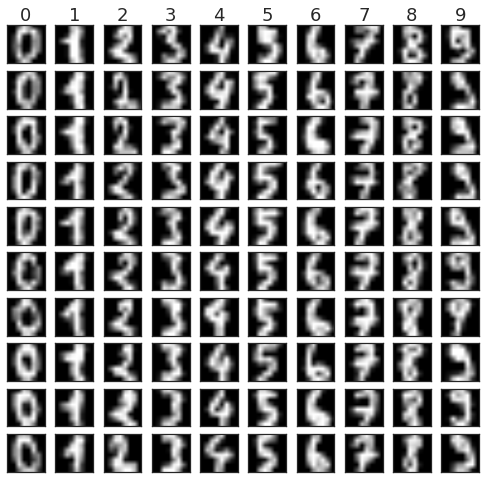

In [12]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()
hd.im_plot(x, y, images)

print('Total number of samples = {0}'.format(y.shape[0]))

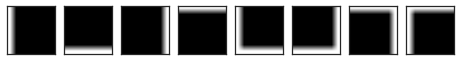

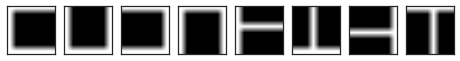

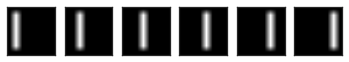

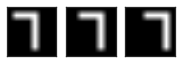

In [13]:
from helper_code import digits as hd

fakes = hd.make_fakes()
hd.plot_numbers(fakes[:8])
hd.plot_numbers(fakes[8:])

ones = hd.make_ones()
hd.plot_numbers(ones)

sevens = hd.make_sevens()
hd.plot_numbers(sevens)

-----

### Identification of image outliers

Now that the data are loaded (and fake data are created), we first
combine the data together into a new array. We have twenty-five _fake_
images, to go along with the _real_ digit data. We perform a PCA
analysis of these combined data, and explore the explained variance from
each PCA component. Finally, we plot the distribution of combined digit
data in two plots. The first uses the primary PCA components, while the
second uses the last two PCA components. These plots demonstrate how a
small number of _noisy_ data, or outliers, can often be identified, and
thus removed, from a data set by transforming into a lower dimensional
space.

-----

In [14]:
# Principal Component Analysis
from sklearn.decomposition import PCA

# Number of fake images
n_fakes = 25

# Compute PCA for digit data and transform
pca = PCA(n_components=8, copy=True)
from sklearn.preprocessing import scale

x2 = x.copy()
x2[x2>0] = 16

xx = np.append(x2, fakes, axis=0)
xx = np.append(xx, ones, axis=0)
xx = np.append(xx, sevens, axis=0)

data = pca.fit_transform(scale(xx))
#pca.transform(fakes).shape

print("Explained Variance per PCA component\n", 35*'-')
for idx, val in enumerate(pca.explained_variance_ratio_):
    print('PCA component {0:2d}: {1:4.1f}%'.format(idx, val*100))
    
print(35*'-', '\nTotal Explained Variance (All PCA components: {0:4.1f}%\n'.format(
 sum(pca.explained_variance_ratio_[:]*100)))

print('Variance explained (First two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[:2]*100)))

print('Variance explained (Last two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[-2:]*100)))

Explained Variance per PCA component
 -----------------------------------
PCA component  0: 12.7%
PCA component  1:  8.4%
PCA component  2:  7.7%
PCA component  3:  6.7%
PCA component  4:  5.4%
PCA component  5:  4.3%
PCA component  6:  3.8%
PCA component  7:  3.5%
----------------------------------- 
Total Explained Variance (All PCA components: 52.6%

Variance explained (First two PCA components): 21.2%

Variance explained (Last two PCA components):  7.3%



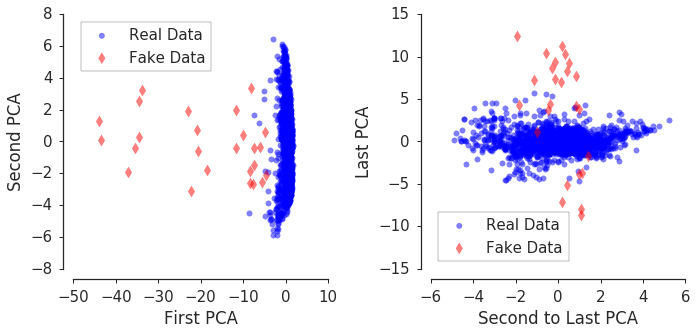

In [15]:
def plot_digit_pca(x, y, idx, ax, llc, xlbl, ylbl):
    
    ax.scatter(x[:-idx], y[:-idx], color='b', marker='o', \
               alpha=0.5, s=30, label='Real Data')
    
    ax.scatter(x[-idx:], y[-idx:], color='r', marker='d', \
               alpha=0.5, s=60, label='Fake Data')

    ax.legend(loc=llc, frameon=True)
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    sns.despine(offset=10)

sns.set(style='white', font_scale=1.5, 
        rc={'xtick.major.size': 4.0, 'ytick.major.size': 4.0})

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_digit_pca(data[:, 0], data[:, 1], n_fakes, axs[0], 2, 'First PCA', 'Second PCA')
plot_digit_pca(data[:, -2], data[:, -1], n_fakes, axs[1], 3, 'Second to Last PCA', 'Last PCA')

plt.tight_layout()

-----

## Student Activity

In the preceding cells, we used PCA to transform the combined digit data
and to explore the distribution of the real data and outliers in
two-dimensional plots by using different PCA components. Now that you
have run the Notebook, go back and make the following changes to see how
the results change.

1. Change the number of PCA components lower and higher. How does this
affect the separation of the outliers?
2. Change the PCA components used to make these plots, for example
to the third and fourth component. How does this affect the separation
of the outliers?
3. Try making a new fake data point that combines the 'bar' image from
the helper code with an existing number, such as a six. Using a
different color ini the plots for this data point, where does this new,
more realistic _fake_ data point lie in the previous plots?

Finally, try applying a classifier on the new digit data. Can you
explain (feel free to use the class forums) why the classification
algorithm performed in the  manner it did for the new _fake_ digits?

-----